主-双対近接分離法による全変動最小化に基づく画像復元(CuPy版)
--

CuPyのインストール
---

In [1]:
!apt -y install libcusparse8.0 libnvrtc8.0 libnvtoolsext1
!ln -snf /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so.8.0 /usr/lib/x86_64-linux-gnu/libnvrtc-builtins.so
!pip install https://github.com/kmaehashi/chainer-colab/releases/download/2018-02-06/cupy_cuda80-4.0.0b3-cp36-cp36m-linux_x86_64.whl
!pip install 'chainer==4.0.0b3'

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  libcusparse8.0 libnvrtc8.0 libnvtoolsext1
0 upgraded, 3 newly installed, 0 to remove and 6 not upgraded.
Need to get 28.9 MB of archives.
After this operation, 71.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libcusparse8.0 amd64 8.0.61-1 [22.6 MB]
Get:2 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvrtc8.0 amd64 8.0.61-1 [6,225 kB]
Get:3 http://archive.ubuntu.com/ubuntu artful/multiverse amd64 libnvtoolsext1 amd64 8.0.61-1 [32.2 kB]
Fetched 28.9 MB in 0s (59.3 MB/s)

78Selecting previously unselected package libcusparse8.0:amd64.
(Reading database ... 18396 files and directories currently installed.)
Preparing to unpack .../libcusparse8.0_8.0.61-1_amd64.deb ...
7Progress: [  0%] [..........................................................] 87Progress: [  6%] [###..

    100% |████████████████████████████████| 205.2MB 120kB/s 
    100% |████████████████████████████████| 81kB 6.6MB/s 
    100% |████████████████████████████████| 368kB 22.8MB/s 
  Running setup.py bdist_wheel for chainer ... - \ | / - done
  Stored in directory: /content/.cache/pip/wheels/7a/e7/26/c13ce14e84f7f2a7209a31f5a1e327b8c681c5bcb3abcd0bec
  Running setup.py bdist_wheel for filelock ... - done
  Stored in directory: /content/.cache/pip/wheels/35/ba/67/4cc48738870c3b54f9e3b5d78bf9de130befb70c1d359faf8b
Successfully built chainer filelock


ファイルのアップロード
---

In [10]:
from google.colab import files
uploaded = files.upload()

Saving Culicoidae256.png to Culicoidae256.png


インポート
---

In [0]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
%matplotlib inline

パラメータ
---

In [0]:
lambda_ = 500
gamma1 = 0.003
gamma2 = 1 / (8 * gamma1)
maxIter = 1000
stopcri = 0.01
cmap = 'gray'

# numpy or cupy
xp = np
# xp = cp

観測データの生成
---

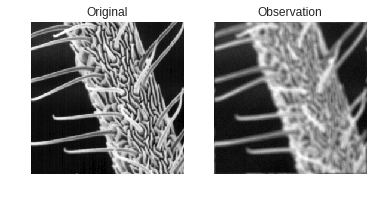

In [35]:
from skimage.io import imread

u_org = imread("Culicoidae256.png", as_grey=True) / 255.
u_org = xp.array(u_org)
rows, cols = u_org.shape
N = rows * cols

# blur operator
psfsize = 7
psf = xp.ones((psfsize, psfsize))
psf /= xp.sum(psf)
blu = xp.zeros(u_org.shape)
blu[:psf.shape[0], :psf.shape[1]] = psf
blu = xp.roll(blu, -(psfsize//2), 0)
blu = xp.roll(blu, -(psfsize//2), 1)
bluf = xp.fft.fft2(blu)
bluft = xp.conj(bluf)
Phi = lambda z: xp.fft.ifft2(xp.fft.fft2(z) * bluf).real
Phit = lambda z: xp.fft.ifft2(xp.fft.fft2(z) * bluft).real

sigma = 2.5 / 255 # noise standard deviation
xp.random.seed(42)
v = Phi(u_org) + sigma * xp.random.randn(rows, cols)

fig, ax = plt.subplots(1, 2)
ax = ax.flatten()

if xp == cp:
  ax[0].imshow(cp.asnumpy(u_org), cmap=cmap)
  ax[1].imshow(cp.asnumpy(v), cmap=cmap)
else:
  ax[0].imshow(u_org, cmap=cmap)
  ax[1].imshow(v, cmap=cmap)

ax[0].set_title('Original')
ax[1].set_title('Observation')

for a in ax:
    a.axis('off')
    
plt.savefig("data.png", dpi=220)

Primal Dual Splitting
---

2.8365890979766846


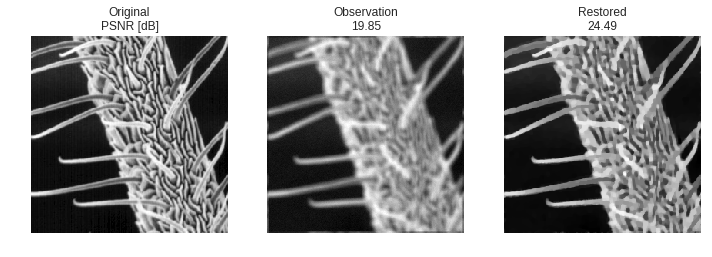

In [36]:
from skimage.measure import compare_psnr
import time

#  difference operator
D = lambda z: xp.dstack((xp.roll(z, -1, 0) - z, xp.roll(z, -1, 1) - z))
Dt = lambda z: xp.r_[-z[:1, :, 0] + z[-1:, :, 0], -z[1:, :, 0] + z[:-1, :, 0]] + xp.c_[-z[:, :1, 1] + z[:, -1:, 1], -z[:, 1:, 1] + z[:, :-1, 1]]

# variables
u = v
z = D(v)

start = time.time()

for i in range(maxIter):
    upre = u.copy()
    
    # update u
    nablaF = lambda_ * Phit(Phi(u) - v)
    u = u - gamma1 * (nablaF + Dt(z))
    u[u > 1] = 1
    u[u < 0] = 0
    
    # update z
    z = z + gamma2 * D(2 * u - upre)
    temp = z / gamma2
    onemat = xp.ones((rows, cols))
    thresh = 1 / xp.sqrt(xp.sum(temp ** 2, 2)) / gamma2
    thresh[thresh > 1] = 1
    coef = onemat - thresh
    temp = xp.dstack((coef, coef)) * temp
    z = z - gamma2 * temp
    
    # stopping condition
    error = u - upre
    error = xp.linalg.norm(error)    
#     print(compare_psnr(u_org, u))
    if error < stopcri:
        break

print(time.time() - start)
      
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax = ax.flatten()

if xp == cp:
  ax[0].imshow(cp.asnumpy(u_org), cmap=cmap)
  ax[1].imshow(cp.asnumpy(v), cmap=cmap)
  ax[2].imshow(cp.asnumpy(u), cmap=cmap)  
else:
  ax[0].imshow(u_org, cmap=cmap)
  ax[1].imshow(v, cmap=cmap)
  ax[2].imshow(u, cmap=cmap)

ax[0].set_title('Original\nPSNR [dB]')
if xp == cp:
  ax[1].set_title('Observation\n{:.2f}'.format(compare_psnr(cp.asnumpy(u_org), cp.asnumpy(v))))
  ax[2].set_title('Restored\n{:.2f}'.format(compare_psnr(cp.asnumpy(u_org), cp.asnumpy(u))))
else:
  ax[1].set_title('Observation\n{:.2f}'.format(compare_psnr(u_org, v)))
  ax[2].set_title('Restored\n{:.2f}'.format(compare_psnr(u_org, u)))

for a in ax:
    a.axis('off')
    
plt.savefig("result.png", dpi=220)

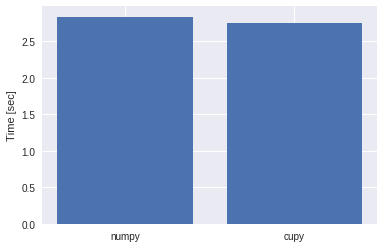

In [55]:
cupy_elapsed_time = 2.752220630645752
numpy_elapsed_time = 2.8365890979766846

plt.bar(np.arange(2), [numpy_elapsed_time, cupy_elapsed_time])
plt.xticks(np.arange(2), ['numpy', 'cupy'])
plt.ylabel('Time [sec]')
plt.show()